### Load documents with IDs

In [2]:
import requests

base_url = "https://github.com/DataTalksClub/llm-zoomcamp/blob/main"
relative_url = "03-vector-search/eval/documents-with-ids.json"
docs_url = f"{base_url}/{relative_url}?raw=1"
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [3]:
documents[-1]

{'text': 'Problem description\nInfrastructure created in AWS with CD-Deploy Action needs to be destroyed\nSolution description\nFrom local:\nterraform init -backend-config="key=mlops-zoomcamp-prod.tfstate" --reconfigure\nterraform destroy --var-file vars/prod.tfvars\nAdded by Erick Calderin',
 'section': 'Module 6: Best practices',
 'question': 'How to destroy infrastructure created via GitHub Actions',
 'course': 'mlops-zoomcamp',
 'id': '886d1617'}

### Load ground truth

In [4]:
import pandas as pd

base_url = "https://github.com/DataTalksClub/llm-zoomcamp/blob/main"
relative_url = "03-vector-search/eval/ground-truth-data.csv"
ground_truth_url = f"{base_url}/{relative_url}?raw=1"

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == "machine-learning-zoomcamp"]
ground_truth = df_ground_truth.to_dict(orient="records")

In [5]:
ground_truth[-1]

{'question': 'Who suggested showcasing progress through LinkedIn posts?',
 'course': 'machine-learning-zoomcamp',
 'document': 'c6a22665'}

In [6]:
doc_idx = {d["id"]: d for d in documents}
print(doc_idx["c6a22665"]["text"])

I’ve seen LinkedIn users list DataTalksClub as Experience with titles as:
Machine Learning Fellow
Machine Learning Student
Machine Learning Participant
Machine Learning Trainee
Please note it is best advised that you do not list the experience as an official “job” or “internship” experience since DataTalksClub did not hire you, nor financially compensate you.
Other ways you can incorporate the experience in the following sections:
Organizations
Projects
Skills
Featured
Original posts
Certifications
Courses
By Annaliese Bronz
Interesting question, I put the link of my project into my CV as showcase and make posts to show my progress.
By Ani Mkrtumyan


### Index data

In [7]:
from sentence_transformers import SentenceTransformer

model_name = "multi-qa-MiniLM-L6-cos-v1"
model = SentenceTransformer(model_name)

In [8]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch("http://localhost:9200")

index_settings = {
    "settings": {"number_of_shards": 1, "number_of_replicas": 0},
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine",
            },
        }
    },
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [9]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc["question"]
    text = doc["text"]
    doc["question_text_vector"] = model.encode(question + " " + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

### Retrieval

In [10]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {"term": {"course": course}},
    }

    search_query = {"knn": knn, "_source": ["text", "section", "question", "course", "id"]}

    es_results = es_client.search(index=index_name, body=search_query)

    result_docs = []

    for hit in es_results["hits"]["hits"]:
        result_docs.append(hit["_source"])

    return result_docs


def question_text_vector_knn(q):
    question = q["question"]
    course = q["course"]

    v_q = model.encode(question)

    return elastic_search_knn("question_text_vector", v_q, course)

In [11]:
question_text_vector_knn(
    dict(question="Are sessions recorded if I miss one?", course="machine-learning-zoomcamp")
)

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

### The RAG flow

In [12]:
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()


def build_prompt(query, search_results):
    context = ""

    for doc in search_results:
        context = (
            context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
        )

    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [16]:
from openai import OpenAI

client = OpenAI()


def llm(prompt, model="gpt-4o"):
    response = client.chat.completions.create(model=model, messages=[{"role": "user", "content": prompt}])

    return response.choices[0].message.content

In [17]:
# previously: rag(query: str) -> str
def rag(query: dict, model="gpt-4o") -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query["question"], search_results)
    answer = llm(prompt, model=model)
    return answer

In [18]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [19]:
rag(ground_truth[10])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'Yes, sessions are recorded if you miss one. You can view the recorded sessions, and you have the option to ask your questions in advance for office hours, which will also be covered during the live stream. Additionally, you can ask questions in Slack at any time.'

In [21]:
doc_idx["5170565b"]["text"]

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [22]:
doc_idx["5170565b"]["question"]

'What if I miss a session?'

### Cosine similarity metric

In [23]:
answer_orig = "Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack."
answer_llm = "Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack."

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

In [24]:
v_llm.dot(v_orig)

0.759117

In [25]:
answers = {}

# for i, rec in enumerate(tqdm(ground_truth)):
#     if i in answers:
#         continue

#     answer_llm = rag(rec)
#     doc_id = rec['document']
#     original_doc = doc_idx[doc_id]
#     answer_orig = original_doc['text']

#     answers[i] = {
#         'answer_llm': answer_llm,
#         'answer_orig': answer_orig,
#         'document': doc_id,
#         'question': rec['question'],
#         'course': rec['course'],
#     }

# results_gpt4o = [None] * len(ground_truth)

# for i, val in answers.items():
#     results_gpt4o[i] = val.copy()
#     results_gpt4o[i].update(ground_truth[i])

In [28]:
import pandas as pd

df_gpt4o = pd.read_csv("data/results-gpt4o.csv")
df_gpt35 = pd.read_csv("data/results-gpt35.csv")

In [30]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [31]:
# from tqdm.auto import tqdm

# from concurrent.futures import ThreadPoolExecutor

# # max_workers -- degree of parallelization -- now there are six concurrent threads
# pool = ThreadPoolExecutor(max_workers=6)


# # f -- function
# # seq -- sequence which we want to execute with function
# def map_progress(pool, seq, f):
#     results = []

#     with tqdm(total=len(seq)) as progress:
#         futures = []

#         for el in seq:
#             future = pool.submit(f, el)
#             future.add_done_callback(lambda p: progress.update())
#             futures.append(future)

#         for future in futures:
#             result = future.result()
#             results.append(result)

#     return results

## Cosine similarity

Groud truth answer -> Question (generated by LLM) -> Answer' (generated by LLM)

#### gpt-4o

In [33]:
results_gpt4o = df_gpt4o.to_dict(orient="records")

In [35]:
results_gpt4o[0]

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [36]:
def compute_similarity(record):
    answer_orig = record["answer_orig"]
    answer_llm = record["answer_llm"]

    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)

    return v_llm.dot(v_orig)

In [37]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [39]:
df_gpt4o["cosine"] = similarity

In [41]:
df_gpt4o["cosine"].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [45]:
# !pip install seaborn

/var/folders/wl/27ymcjln6px3tcfww0c_jg5c0000gn/T/ipykernel_33988/1258996142.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o["cosine"], label="4o")
/var/folders/wl/27ymcjln6px3tcfww0c_jg5c0000gn/T/ipykernel_33988/1258996142.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35

Text(0.5, 0, "A->Q->A' Cosine Similarity")

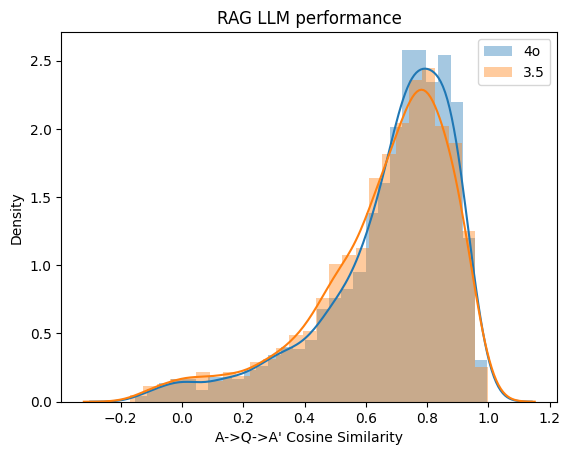

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df_gpt4o["cosine"], label="4o")
sns.distplot(df_gpt35["cosine"], label="3.5")
sns.distplot(df_gpt4o_mini["cosine"], label="4o-mini")

plt.legend()
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")

#### gpt-3.5-turbo

In [42]:
results_gpt35 = df_gpt35.to_dict(orient="records")

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [43]:
df_gpt35["cosine"] = similarity_35
df_gpt35["cosine"].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546505
50%         0.714784
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

#### gpt-4o-mini

In [54]:
df_gpt4o_mini = pd.read_csv("data/results-gpt4o-mini.csv")

In [61]:
results_gpt4omini = df_gpt4o_mini.to_dict(orient="records")

In [62]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [67]:
df_gpt4o_mini["cosine"] = similarity_4o_mini
df_gpt4o_mini["cosine"].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

/var/folders/wl/27ymcjln6px3tcfww0c_jg5c0000gn/T/ipykernel_33988/169920860.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o["cosine"], label="4o")
/var/folders/wl/27ymcjln6px3tcfww0c_jg5c0000gn/T/ipykernel_33988/169920860.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35["

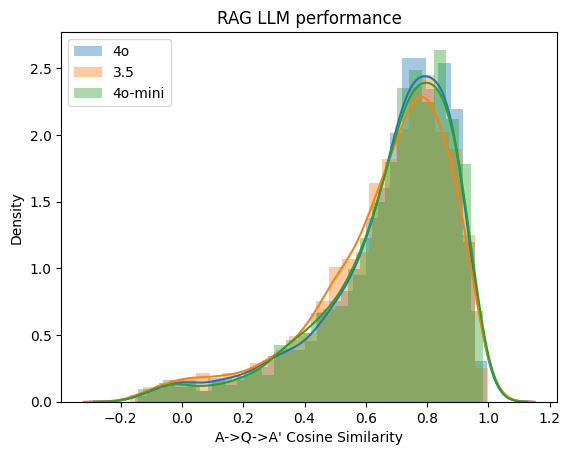

In [68]:
sns.distplot(df_gpt4o["cosine"], label="4o")
sns.distplot(df_gpt35["cosine"], label="3.5")
sns.distplot(df_gpt4o_mini["cosine"], label="4o-mini")

plt.legend()
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.show()

## LLM-as-a-Judge

In [69]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [80]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)
samples = df_sample.to_dict(orient="records")

In [73]:
# evaluations = []

# for record in tqdm(samples):
#     prompt = prompt1_template.format(**record)
#     evaluation = llm(prompt, model='gpt-4o-mini')
#     evaluations.append(evaluation)

In [ ]:
# json_evaluations = []

# for i, str_eval in enumerate(evaluations):
#     json_eval = json.loads(str_eval)
#     json_evaluations.append(json_eval)

In [71]:
df_evaluations = pd.read_csv("data/evaluations-aqa.csv")
df_evaluations_2 = pd.read_csv("data/evaluations-qa.csv")

In [76]:
df_evaluations["Relevance"].value_counts()

Relevance
RELEVANT           124
PARTLY_RELEVANT     16
NON_RELEVANT        10
Name: count, dtype: int64

In [77]:
df_evaluations_2["Relevance"].value_counts()

Relevance
RELEVANT           129
PARTLY_RELEVANT     18
NON_RELEVANT         3
Name: count, dtype: int64

In [87]:
len(df_evaluations[df_evaluations["Relevance"] == "RELEVANT"]) / len(df_evaluations)

0.8266666666666667

In [86]:
df_evaluations[df_evaluations["Relevance"] != "RELEVANT"]

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a pip version e...
11,NON_RELEVANT,The generated answer does not address the spec...
24,PARTLY_RELEVANT,The generated answer addresses part of the ori...
27,NON_RELEVANT,The generated answer incorrectly states that t...
29,PARTLY_RELEVANT,The generated answer correctly identifies the ...
31,PARTLY_RELEVANT,The generated answer addresses the general ide...
41,NON_RELEVANT,The generated answer provides information abou...
44,PARTLY_RELEVANT,The generated answer provides specific informa...
45,PARTLY_RELEVANT,The generated answer acknowledges that the ori...
46,PARTLY_RELEVANT,The generated answer addresses the question of...


In [82]:
samples[11]

{'answer_llm': 'To resolve the NotSupportedError in section 5, you can take the following steps:\n\n1. **Downgrade the protobuf package**: The recommended version is 3.20.1. You can do this by running the following command:\n   ```bash\n   pipenv install protobuf==3.20.1\n   ```\n\n2. **Regenerate your Protobuf files**: If you have access to the source files and can regenerate them, ensure that you use `protoc` version 3.19.0 or higher.\n\n3. **Alternative workaround**: If you cannot regenerate your protos, you can either downgrade the protobuf package to version 3.20.x or lower, or set the environment variable:\n   ```bash\n   export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python\n   ```\n   Note that the latter will use a slower pure-Python parser.\n\nMake sure to follow these steps to address the issue effectively.',
 'answer_orig': 'Question:\nWhen executing\neb local run  --port 9696\nI get the following error:\nERROR: NotSupportedError - You can use "eb local" only with preconfigu